# **DTSA 5511 Week 3 Assignment**



### **Instructions: Step 1**

- Brief description of the problem and data (5 pts) 

- Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

This Kaggle challenge invites participants to develop an algorithm that can precisely detect metastatic cancer in small image patches extracted from larger digital pathology scans. According to Kaggle, the data provided for this competition is a modified version of the PatchCamelyon (PCam) benchmark dataset, containing a large number of small pathology images to classify.

The challenge is to accurately identifying whether the center 32x32px region of a patch contains at least one pixel of tumor tissue, while ignoring tumor tissue in the outer region of the patch. This challenge requires the development of a model that can accurately distinguish between the tumor and non-tumor tissues in the image patches.

The data provided consists of a training set of images and corresponding binary labels indicating whether the center 32x32px region of the patch contains tumor tissue or not. The testing set consists of similar image patches without corresponding labels. The image patches are in RGB format with dimensions of 96x96 pixels. The dataset contains approximately 220k training images and 57k testing images.




In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
import shutil
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tabulate import tabulate

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### **Instructions: Step 2**

- Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

- Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

First, I downloaded the dataset zip file from Kaggle and unzipped it to my local drive. Since the images were in TIF format and Keras does not support TIF format, I created a function to convert the images to PNG format for compatibility with Keras.

Next, I created a function to split the images into two subfolders - one for images with tumors and one for images without tumors - in the training data. This made it easier to work with the images and ensured that they were correctly labeled.

Then, I normalized the the images by dividing them by 255, followed by performed data augmentation on the training set using rotation, zoom, and horizontal flip. This helps to increase the diversity of the images in the training set and can prevent overfitting.

To get a better sense of the images, I plotted the first nine images in the training dataset using Matplotlib. This allowed me to see what the images looked like and get a sense of any patterns or features that may be present.

Then, I plotted a histogram of the class labels, which showed that the dataset was balanced. I also randomly selected an image from each class and plotted them along with their color distributions. This gave me a sense of what the images looked like and how the pixel values were distributed.

Overall, there were no significant data cleaning procedures required for this dataset. The images were already in good condition and properly labeled.

Based on my EDA, my plan of analysis is to use a convolutional neural network (CNN) to classify the images into the two categories: tumor or no tumor. I will start with a simple CNN architecture and then fine-tune the model as needed based on the results.

In [3]:
def convert_tif(tif_folder):
    # Loop through each file in the folder
    for file_name in os.listdir(tif_folder):

        # Check if the file is a tif file
        if file_name.endswith('.tif'):
            # Open the tif file and convert it to png format
            tif_path = os.path.join(tif_folder, file_name)
            img = Image.open(tif_path)
            png_path = os.path.splitext(tif_path)[0] + '.png'
            img.save(png_path)

            # Delete the original tif file
            os.remove(tif_path)

In [4]:
def create_folders(tif_folder):
    class1_folder = os.path.join(tif_folder, 'class1')
    class2_folder = os.path.join(tif_folder, 'class2')
    if not os.path.exists(class1_folder):
        os.makedirs(class1_folder)
    if not os.path.exists(class2_folder):
        os.makedirs(class2_folder)

    for index, row in training_labels.iterrows():
        # Extract the image name and class label
        img_name = row['id'] + '.png'
        class_label = row['label']

        # Create the destination folder for the image based on the class label
        if class_label == 0:
            dest_folder = class1_folder
        else:
            dest_folder = class2_folder

        # Move the image to the destination folder
        src_path = os.path.join(tif_folder, img_name)
        dest_path = os.path.join(dest_folder, img_name)
        shutil.move(src_path, dest_path)

In [5]:
training_labels = pd.read_csv("train_labels.csv")

In [6]:
train_folder = './train'
#convert_tif(train_folder)
#create_folders(train_folder)

In [7]:
test_folder = './test'
#convert_tif(test_folder)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=20, # randomly rotate images by 20 degrees
    zoom_range=0.2, # randomly zoom images by 20%
    horizontal_flip=True # randomly flip images horizontally
)

train_dataset = train_datagen.flow_from_directory(
    train_folder,
    target_size=(96, 96),
    batch_size=16,
    class_mode='binary',
    subset='training')

validation_dataset = train_datagen.flow_from_directory(
    train_folder,
    target_size=(96, 96),
    batch_size=16,
    class_mode='binary',
    subset='validation')

Found 176021 images belonging to 2 classes.
Found 44004 images belonging to 2 classes.


In [9]:
test_datagen = ImageDataGenerator()

test_dataset = test_datagen.flow_from_directory(
    directory='./',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['test']
)

Found 57458 images belonging to 1 classes.


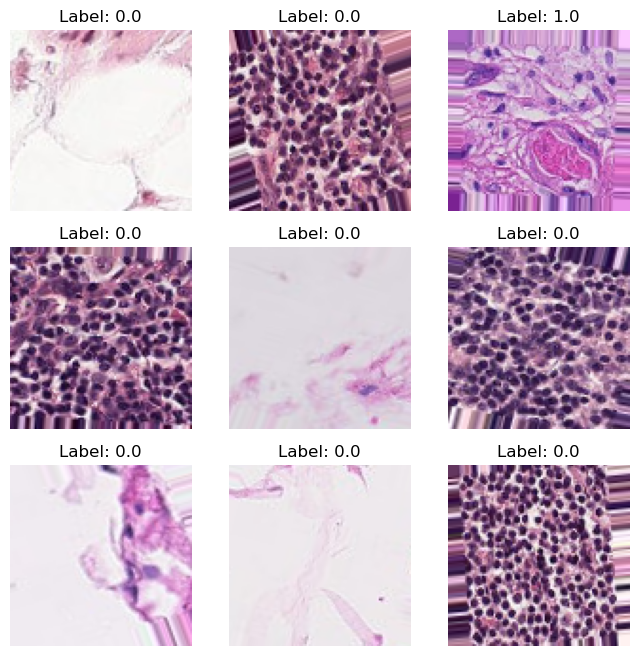

In [10]:
# get the first 9 images from the train dataset
images, labels = next(train_dataset)

# plot the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')

plt.show()


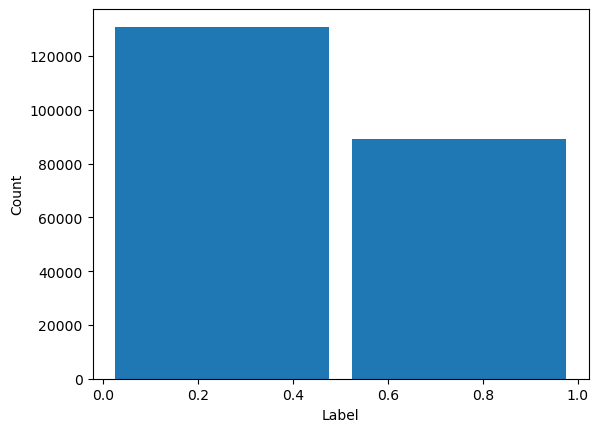

In [11]:
plt.hist(training_labels['label'], bins=2, rwidth=0.9)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

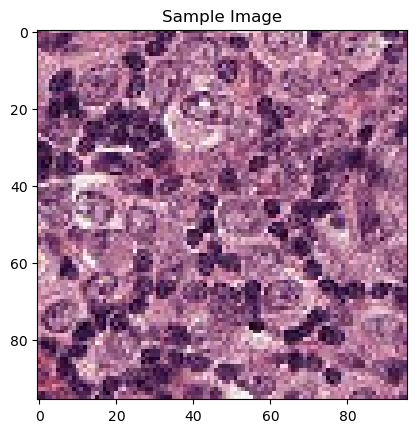

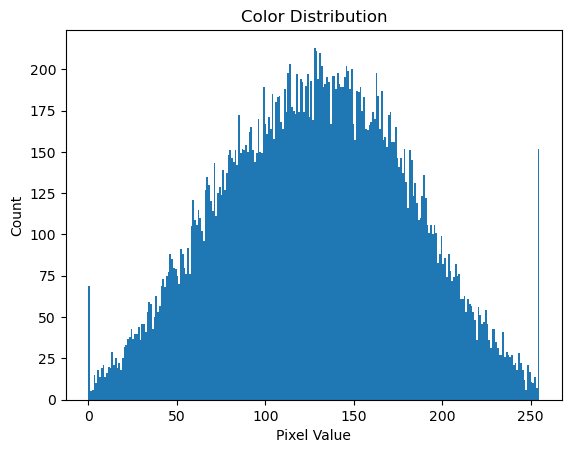

In [12]:
# randomly select a class
class_name = np.random.choice(['class1', 'class2'])

# randomly select an image from the chosen class
img_path = os.path.join(train_folder, class_name, np.random.choice(os.listdir(os.path.join(train_folder, class_name))))

# load the image and plot it
img = imread(img_path)
plt.imshow(img)
plt.title('Sample Image')
plt.show()

# plot the color distribution
plt.hist(img.ravel(), bins=256, range=(0, 255))
plt.title('Color Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.show()


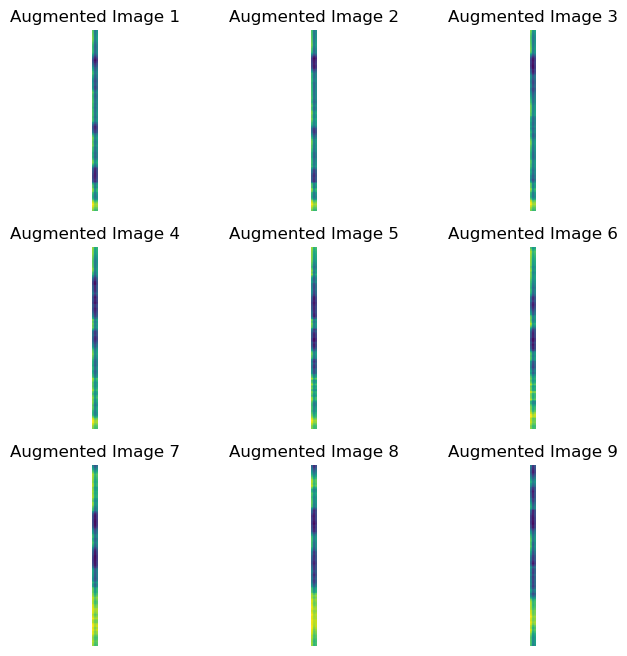

In [13]:
# get a batch of augmented images
aug_images = next(train_datagen.flow(images, batch_size=9))[0]

# plot the augmented images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(aug_images[i])
    ax.set_title('Augmented Image {}'.format(i+1))
    ax.axis('off')

plt.show()

### **Instructions: Step 3**
 
- DModel Architecture (25 pts)

- Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

In this section, I made three different convolutional neural network (CNN) models. The first model had three blocks, each with two convolutional layers, a max pooling layer, a dropout layer, and a dense layer. The number of filters increased in each block, and the model had a dense output layer with a sigmoid activation function. I trained the first model for 10 epochs, and I used the EarlyStopping callback to prevent overfitting. 

For the second model, I used the same architecture as the first model, but I made some modifications. The third model was different from the other two in architecture. I compiled and trained the second and third models using the same parameters as the first model, and I plotted the training and validation accuracy and loss curves for all three models.

Model 1 performed the worst among the three models with a relatively high loss and lower accuracy compared to Models 2 and 3. However, I chose Model 1 for hyperparameter tuning because it had the most potential for improvement. It had a simple architecture, which leaves room for optimization of hyperparameters such as the number of filters, kernel size, and learning rate. Additionally, Model 1 showed the most improvement during training, indicating that it may benefit from further fine-tuning of its parameters. While Models 2 and 3 achieved better accuracy, they might not generalize well to new, unseen data. By selecting Model 1 for hyperparameter tuning, we can potentially improve its performance and achieve better generalization on future data.

In [14]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [15]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(train_dataset, 
                    epochs=10, 
                    steps_per_epoch = len(train_dataset)//16, 
                    validation_steps = len(validation_dataset)//16, 
                    validation_data=validation_dataset,
                    callbacks=EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/10
687/687 [==============================] - 51s 67ms/step - loss: 0.6040 - accuracy: 0.6671 - val_loss: 0.6862 - val_accuracy: 0.5219
Epoch 2/10
687/687 [==============================] - 46s 67ms/step - loss: 0.5062 - accuracy: 0.7654 - val_loss: 0.6767 - val_accuracy: 0.5563
Epoch 3/10
687/687 [==============================] - 46s 66ms/step - loss: 0.4911 - accuracy: 0.7762 - val_loss: 0.6606 - val_accuracy: 0.6012
Epoch 4/10
687/687 [==============================] - 70s 101ms/step - loss: 0.4724 - accuracy: 0.7836 - val_loss: 0.5649 - val_accuracy: 0.7167
Epoch 5/10
687/687 [==============================] - 72s 104ms/step - loss: 0.4759 - accuracy: 0.7797 - val_loss: 0.6059 - val_accuracy: 0.6795
Epoch 6/10
687/687 [==============================] - 67s 97ms/step - loss: 0.4638 - accuracy: 0.7875 - val_loss: 0.5912 - val_accuracy: 0.6820
Epoch 7/10
687/687 [==============================] - 67s 97ms/step - loss: 0.4614 - accuracy: 0.7870 - val_loss: 0.5794 - val_accurac

Text(0.5, 1.0, 'Training and Validation Accuracy')

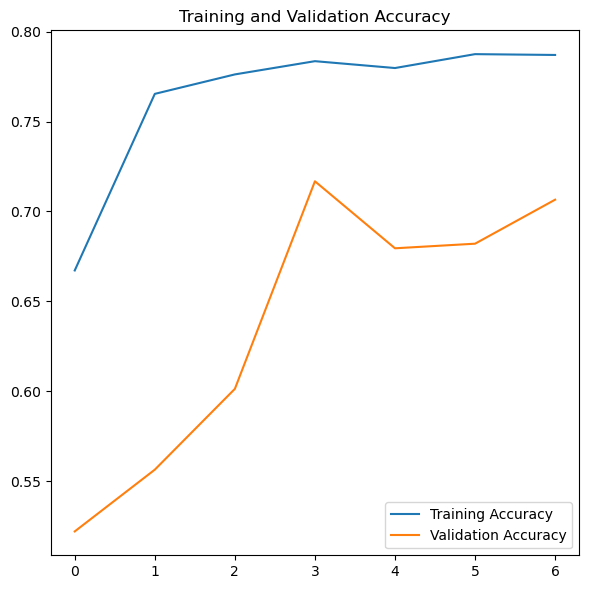

In [17]:
# Plot training and validation accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(7)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

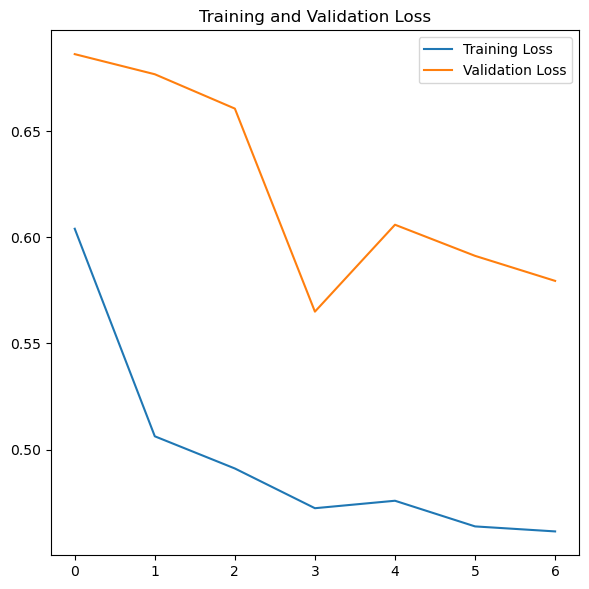

In [18]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
table_data = [
    [1, 0.6040, 0.6671, 0.6862, 0.5219],
    [2, 0.5062, 0.7654, 0.6767, 0.5563],
    [3, 0.4911, 0.7762, 0.6606, 0.6012],
    [4, 0.4724, 0.7836, 0.5649, 0.7167],
    [5, 0.4759, 0.7797, 0.6059, 0.6795],
    [6, 0.4638, 0.7875, 0.5912, 0.6820],
    [7, 0.4614, 0.7870, 0.5794, 0.7065]
]

headers = ["Epoch", "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]

table = tabulate(table_data, headers, tablefmt="grid")
print(table)

+---------+-----------------+---------------------+-------------------+-----------------------+
|   Epoch |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+=========+=================+=====================+===================+=======================+
|       1 |          0.604  |              0.6671 |            0.6862 |                0.5219 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       2 |          0.5062 |              0.7654 |            0.6767 |                0.5563 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       3 |          0.4911 |              0.7762 |            0.6606 |                0.6012 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       4 |          0.4724 |              0.7836 |            0.5649 |                0.7167 |
+---------+-----------------+-----------

In [20]:
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [21]:
model2.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
history2 = model2.fit(train_dataset, 
                    epochs=10, 
                    steps_per_epoch = len(train_dataset)//16, 
                    validation_steps = len(validation_dataset)//16, 
                    validation_data=validation_dataset,
                    callbacks=EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/10
687/687 [==============================] - 67s 96ms/step - loss: 0.5782 - accuracy: 0.6911 - val_loss: 0.5157 - val_accuracy: 0.7548
Epoch 2/10
687/687 [==============================] - 68s 99ms/step - loss: 0.4933 - accuracy: 0.7712 - val_loss: 0.4683 - val_accuracy: 0.7836
Epoch 3/10
687/687 [==============================] - 65s 95ms/step - loss: 0.4824 - accuracy: 0.7757 - val_loss: 0.4837 - val_accuracy: 0.7840
Epoch 4/10
687/687 [==============================] - 63s 91ms/step - loss: 0.4631 - accuracy: 0.7932 - val_loss: 0.4594 - val_accuracy: 0.8048
Epoch 5/10
687/687 [==============================] - 60s 87ms/step - loss: 0.4365 - accuracy: 0.8044 - val_loss: 0.4489 - val_accuracy: 0.8041
Epoch 6/10
687/687 [==============================] - 61s 89ms/step - loss: 0.4389 - accuracy: 0.8039 - val_loss: 0.4172 - val_accuracy: 0.8213
Epoch 7/10
687/687 [==============================] - 60s 87ms/step - loss: 0.4215 - accuracy: 0.8138 - val_loss: 0.4808 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation Accuracy')

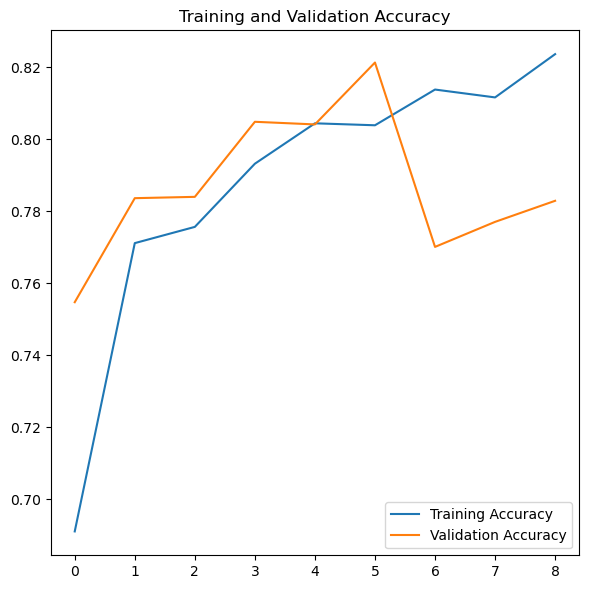

In [23]:
# Plot training and validation accuracy curves
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs_range2 = range(9)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

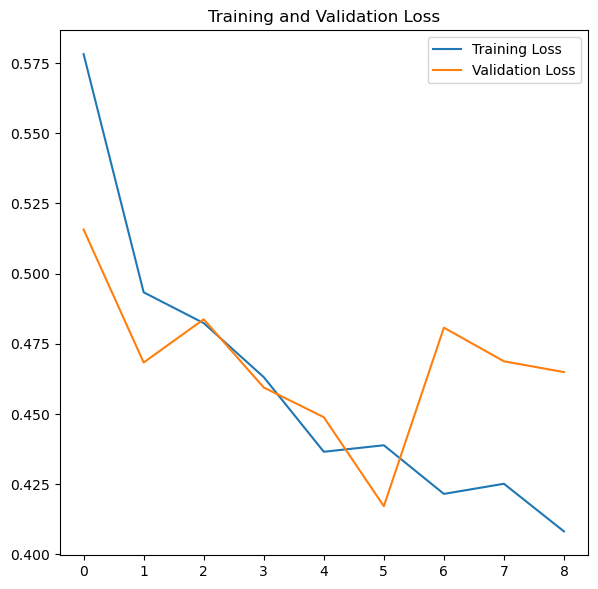

In [24]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 2)
plt.plot(epochs_range2, loss2, label='Training Loss')
plt.plot(epochs_range2, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
table_data2 = [
    [1, 0.5782, 0.6911, 0.5157, 0.7548],
    [2, 0.4933, 0.7712, 0.4683, 0.7836],
    [3, 0.4824, 0.7757, 0.4837, 0.7840],
    [4, 0.4631, 0.7932, 0.4594, 0.8048],
    [5, 0.4365, 0.8044, 0.4489, 0.8041],
    [6, 0.4389, 0.8039, 0.4172, 0.8213],
    [7, 0.4215, 0.8138, 0.4808, 0.7701],
    [8, 0.4251, 0.8116, 0.4688, 0.7770],
    [9, 0.4082, 0.8236, 0.4649, 0.7829],
]

table2 = tabulate(table_data2, headers, tablefmt="grid")
print(table2)

+---------+-----------------+---------------------+-------------------+-----------------------+
|   Epoch |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+=========+=================+=====================+===================+=======================+
|       1 |          0.5782 |              0.6911 |            0.5157 |                0.7548 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       2 |          0.4933 |              0.7712 |            0.4683 |                0.7836 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       3 |          0.4824 |              0.7757 |            0.4837 |                0.784  |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       4 |          0.4631 |              0.7932 |            0.4594 |                0.8048 |
+---------+-----------------+-----------

In [38]:
model3 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])


In [39]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
history3 = model3.fit(train_dataset, 
                    epochs=10, 
                    steps_per_epoch = len(train_dataset)//16, 
                    validation_steps = len(validation_dataset)//16, 
                    validation_data=validation_dataset,
                    callbacks=EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/10
687/687 [==============================] - 42s 61ms/step - loss: 0.6741 - accuracy: 0.7132 - val_loss: 0.4868 - val_accuracy: 0.7924
Epoch 2/10
687/687 [==============================] - 43s 63ms/step - loss: 0.5331 - accuracy: 0.7541 - val_loss: 0.4916 - val_accuracy: 0.7792
Epoch 3/10
687/687 [==============================] - 43s 63ms/step - loss: 0.5266 - accuracy: 0.7546 - val_loss: 0.4544 - val_accuracy: 0.8034
Epoch 4/10
687/687 [==============================] - 43s 62ms/step - loss: 0.5193 - accuracy: 0.7666 - val_loss: 0.4747 - val_accuracy: 0.7957
Epoch 5/10
687/687 [==============================] - 41s 60ms/step - loss: 0.4977 - accuracy: 0.7750 - val_loss: 0.4747 - val_accuracy: 0.7814
Epoch 6/10
687/687 [==============================] - 41s 59ms/step - loss: 0.4929 - accuracy: 0.7799 - val_loss: 0.4510 - val_accuracy: 0.8088
Epoch 7/10
687/687 [==============================] - 40s 59ms/step - loss: 0.4961 - accuracy: 0.7785 - val_loss: 0.4844 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation Accuracy')

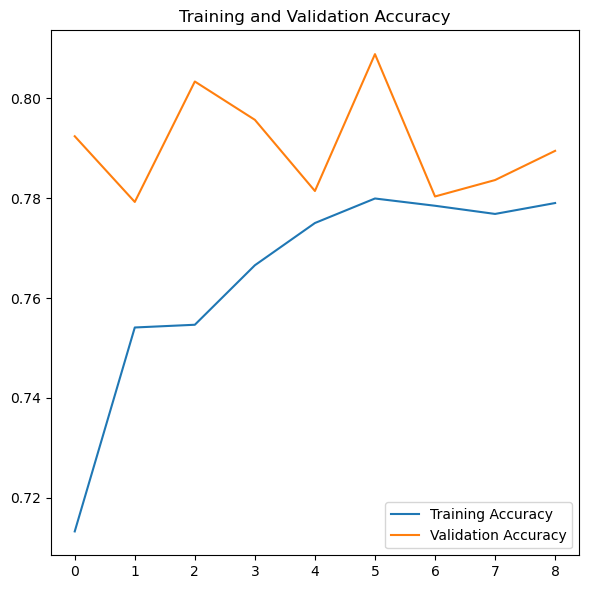

In [41]:
# Plot training and validation accuracy curves
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs_range3 = range(9)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range3, acc3, label='Training Accuracy')
plt.plot(epochs_range3, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

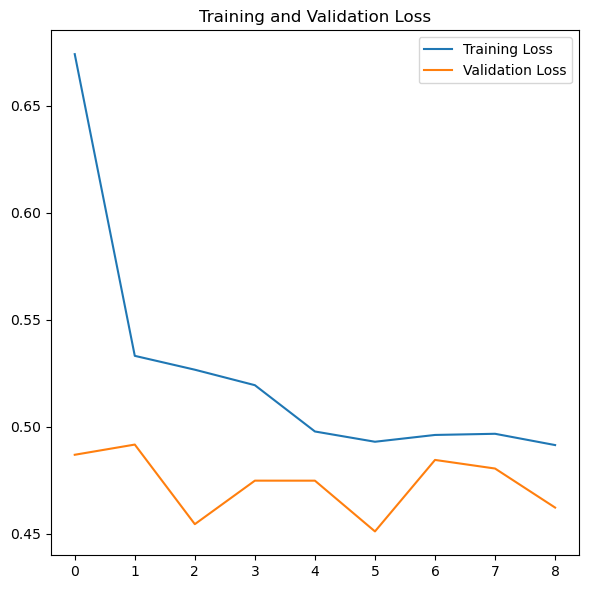

In [42]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 2)
plt.plot(epochs_range3, loss3, label='Training Loss')
plt.plot(epochs_range3, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [66]:
table_data3 = [
    [1, 0.6741, 0.7132, 0.4868, 0.7924],
    [2, 0.5331, 0.7541, 0.4916, 0.7792],
    [3, 0.5266, 0.7546, 0.4544, 0.8034],
    [4, 0.5193, 0.7666, 0.4747, 0.7957],
    [5, 0.4977, 0.7750, 0.4747, 0.7814],
    [6, 0.4929, 0.7799, 0.4510, 0.8088],
    [7, 0.4961, 0.7785, 0.4844, 0.7803],
    [8, 0.4966, 0.7768, 0.4804, 0.7836],
    [9, 0.4913, 0.7790, 0.4621, 0.7895]
]

table3 = tabulate(table_data3, headers, tablefmt="grid")
print(table3)

+---------+-----------------+---------------------+-------------------+-----------------------+
|   Epoch |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+=========+=================+=====================+===================+=======================+
|       1 |          0.6741 |              0.7132 |            0.4868 |                0.7924 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       2 |          0.5331 |              0.7541 |            0.4916 |                0.7792 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       3 |          0.5266 |              0.7546 |            0.4544 |                0.8034 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       4 |          0.5193 |              0.7666 |            0.4747 |                0.7957 |
+---------+-----------------+-----------

### **Instructions: Step 4**
 
Results and Analysis (35 pts) 

- Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

- Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

For the hyperparameter tuning portion, I designed the structure of my model same as the model I have chosen for the previous step.The model is compiled with the Adam optimizer, binary cross-entropy loss function, and accuracy metric.

Next, I instantiated a RandomSearch tuner from the Keras Tuner library. The tuner is configured to search for the best hyperparameters for the model by optimizing the validation accuracy. It performs a search with a maximum of 10 trials and 3 executions per trial. The results and checkpoints of the tuner are stored in the 'DTSA_5511' directory with the project name 'Week3'.

I then performed the hyperparameter search using the tuner.search() method. The training and validation datasets are provided, along with the number of steps per epoch and validation steps. The search is performed for 10 epochs, and an EarlyStopping callback is used to monitor the validation loss and stop training if it doesn't improve for 3 consecutive epochs.

After the hyperparameter search is complete, I obtained the best hyperparameters using tuner.get_best_hyperparameters(). The best learning rate is printed to the console.

I rebuilt the model with the best hyperparameters using tuner.hypermodel.build() and trained it on the full training set for 100 epochs. The training progress is displayed, including the loss and accuracy for each epoch.

Same as previous section, I plotted the graphs using Matplotlib to visualize the training and validation accuracy and loss curves, then created a table containing the training and validation metrics for each epoch.

Finally, I made predictions on the test dataset using the best model and saved the predictions in a CSV file named 'submission.csv', along with the corresponding file names. The predictions are also displayed as a DataFrame for verification. This was then uploaded and submitted to Kaggle.

In [45]:
def build_model(hp):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [46]:
# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='DTSA_5511',
    project_name='Week3'
)

In [47]:
# Perform the hyperparameter search
tuner.search(train_dataset,
             steps_per_epoch=len(train_dataset)//16,
             validation_data=validation_dataset,
             validation_steps=len(validation_dataset)//16,
             epochs=10,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Trial 10 Complete [00h 16m 57s]
val_accuracy: 0.8240740696589152

Best val_accuracy So Far: 0.8240740696589152
Total elapsed time: 02h 49m 46s
INFO:tensorflow:Oracle triggered exit


In [48]:
# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Best hyperparameters: {'learning_rate': 0.0004829761874275567}


In [58]:
# Rebuild the model with the best hyperparameters and train it on the full training set
best_model = tuner.hypermodel.build(best_hps)
best_model_hist = best_model.fit(train_dataset, 
                    epochs=100, 
                    steps_per_epoch = len(train_dataset)//16, 
                    validation_steps = len(validation_dataset)//16, 
                    validation_data=validation_dataset,
                    callbacks=EarlyStopping(monitor='val_loss', patience=3))

Epoch 1/100
687/687 [==============================] - 45s 64ms/step - loss: 0.5291 - accuracy: 0.7383 - val_loss: 0.5155 - val_accuracy: 0.7719
Epoch 2/100
687/687 [==============================] - 52s 76ms/step - loss: 0.4929 - accuracy: 0.7674 - val_loss: 0.4446 - val_accuracy: 0.7957
Epoch 3/100
687/687 [==============================] - 53s 77ms/step - loss: 0.4716 - accuracy: 0.7860 - val_loss: 0.4367 - val_accuracy: 0.8158
Epoch 4/100
687/687 [==============================] - 56s 81ms/step - loss: 0.4494 - accuracy: 0.7962 - val_loss: 0.4638 - val_accuracy: 0.8019
Epoch 5/100
687/687 [==============================] - 54s 79ms/step - loss: 0.4386 - accuracy: 0.8006 - val_loss: 0.4081 - val_accuracy: 0.8271
Epoch 6/100
687/687 [==============================] - 52s 76ms/step - loss: 0.4247 - accuracy: 0.8123 - val_loss: 0.4037 - val_accuracy: 0.8235
Epoch 7/100
687/687 [==============================] - 53s 77ms/step - loss: 0.4124 - accuracy: 0.8154 - val_loss: 0.4626 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

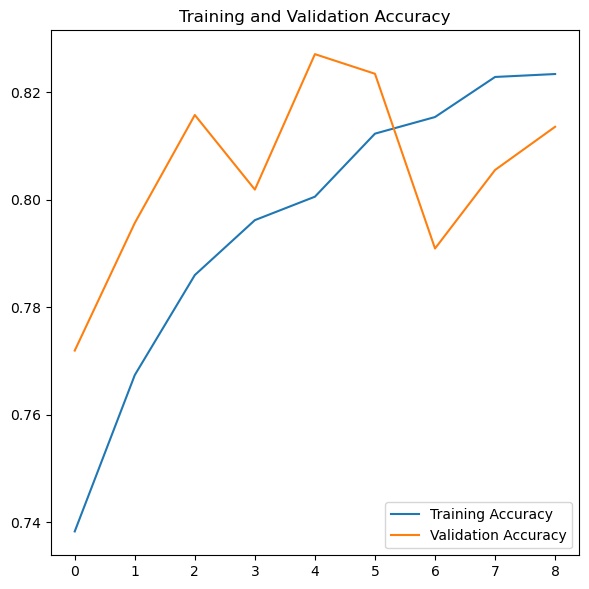

In [59]:
# Plot training and validation accuracy curves
bm_ac = best_model_hist.history['accuracy']
bm_val_acc = best_model_hist.history['val_accuracy']
bm_loss = best_model_hist.history['loss']
bm_val_loss = best_model_hist.history['val_loss']
bm_epochs_range = range(9)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(bm_epochs_range, bm_ac, label='Training Accuracy')
plt.plot(bm_epochs_range, bm_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

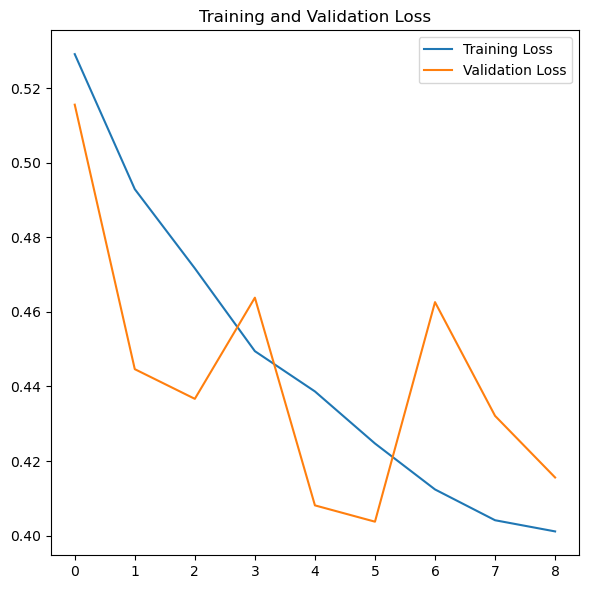

In [60]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 2)
plt.plot(bm_epochs_range, bm_loss, label='Training Loss')
plt.plot(bm_epochs_range, bm_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
table_data_final = [
    [1, 0.5291, 0.7383, 0.5155, 0.7719],
    [2, 0.4929, 0.7674, 0.4446, 0.7957],
    [3, 0.4716, 0.7860, 0.4367, 0.8158],
    [4, 0.4494, 0.7962, 0.4638, 0.8019],
    [5, 0.4386, 0.8006, 0.4081, 0.8271],
    [6, 0.4274, 0.8123, 0.4037, 0.8235],
    [7, 0.4124, 0.8154, 0.4626, 0.7909],
    [8, 0.4041, 0.8229, 0.4321, 0.8056],
    [9, 0.4011, 0.8234, 0.4156, 0.8136]
]

table_final = tabulate(table_data_final, headers, tablefmt="grid")
print(table_final)

+---------+-----------------+---------------------+-------------------+-----------------------+
|   Epoch |   Training Loss |   Training Accuracy |   Validation Loss |   Validation Accuracy |
+=========+=================+=====================+===================+=======================+
|       1 |          0.5291 |              0.7383 |            0.5155 |                0.7719 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       2 |          0.4929 |              0.7674 |            0.4446 |                0.7957 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       3 |          0.4716 |              0.786  |            0.4367 |                0.8158 |
+---------+-----------------+---------------------+-------------------+-----------------------+
|       4 |          0.4494 |              0.7962 |            0.4638 |                0.8019 |
+---------+-----------------+-----------

In [62]:
pred = best_model.predict(test_dataset)

In [68]:
file_names = test_dataset.filenames
ids = [os.path.splitext(os.path.basename(file_name))[0] for file_name in file_names]
submission = pd.DataFrame({'id': ids, 'label': pred.reshape(-1)})
submission['label'] = submission['label'].astype(int)
submission.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [69]:
submission.to_csv('submission.csv', index=False)

### **Instructions: Step 5**
 
Conclusion (15 pts)

- Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In conclusion, I participated in the Kaggle challenge for this week's assignment to develop an algorithm for the detection of metastatic cancer in small image patches. I performed various steps to preprocess the data, including converting images to PNG format, splitting them into tumor and non-tumor subfolders, and applying data augmentation techniques. I then implemented three different convolutional neural network (CNN) models and compared their performance.

Among the three models, Model 1 showed the most potential for improvement, despite initially performing the worst. It had a simple architecture and showed significant improvement during training, suggesting the need for hyperparameter tuning. I used the Keras Tuner library to perform a random search for the best hyperparameters. After completing the hyperparameter search, I obtained the best learning rate and rebuilt the model with the optimal hyperparameters.

By using the Keras Tuner library, I fine-tuned the model's hyperparameters and identified the optimal learning rate, further improving its performance. However, the model's public and private scores on Kaggle were relatively low, indicating that it may not perform as well on different test data.

Throughout this challenge, I learned the importance of preprocessing and data augmentation techniques in improving the performance of CNN models. I also gained experience in hyperparameter tuning and model evaluation. Additionally, I discovered the potential of early stopping to prevent overfitting.

Although the implemented models achieved moderate success, there is room for improvement. One suggestion for future iterations would be to explore more complex CNN architectures and experiment with different optimization algorithms. Additionally, increasing the diversity and size of the training dataset could help improve generalization. Finally, incorporating ensemble methods or transfer learning techniques may further enhance the model's performance.


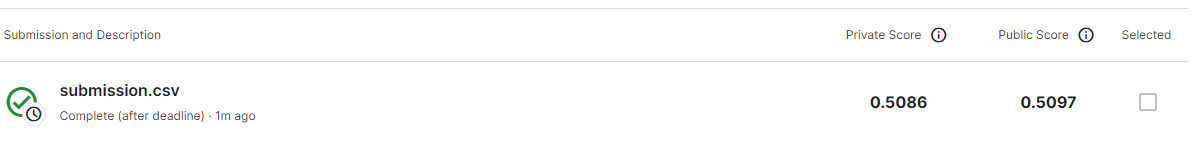